# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [1]:
%run "/code/source/config/notebook_settings.py"

In [2]:
from itertools import islice
import pandas as pd
from helpsk.logging import Timer
from helpsk.pandas import non_numeric_summary, numeric_summary
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, \
    count_keywords, count_keywords_by, impurity
from source.library.notebook_helpers import plot_hdi, percentiles
from source.library.datasets import DATA

pd.set_option('display.max_colwidth', None)

In [3]:
with Timer("Loading Data"):
    reddit = DATA.reddit.load()
    reddit_corpus = DATA.reddit_corpus.load()

2023-04-12 02:54:40 - INFO     | Timer Started: Loading Data
2023-04-12 02:54:40 - INFO     | Loading data `reddit` from `/code/artifacts/data/raw/reddit.pkl`
2023-04-12 02:54:40 - INFO     | Loading Corpus object from `/code/artifacts/data/processed/reddit_corpus__json`
2023-04-12 02:56:08 - INFO     | Timer Finished: (87.51 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [4]:
reddit.head(1)

,id,subreddit,title,post
0,8f73s7,Harley,No Club Colors,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!"


### Numeric Summary

In [5]:
numeric_summary(reddit)

### Non-Numeric

In [6]:
non_numeric_summary(reddit)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
id,"20,000",0,0.0%,8f73s7,"20,000",100.0%
subreddit,"20,000",0,0.0%,Harley,20,0.1%
title,"20,000",0,0.0%,Need some advice,"19,957",99.8%
post,"20,000",0,0.0%,Funny story. I went to college[...],"20,000",100.0%


In [7]:
reddit_corpus.to_dataframe(columns='all', first_n=2)

,text_original,text_clean,lemmas_all,lemmas_important,bi_grams,nouns,noun_phrases,adjective_verbs,sentiment,impurity_original,impurity_clean,text_clean_length,text_original_length,num_tokens_all,num_tokens_important_only
0,"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!","Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. Cheers. Ride safe, boys!","[funny, story, ., i, go, to, college, in, las, vegas, ., this, be, before, i, know, anything, about, motorcycle, whatsoever, ., i, and, some, college, buddy, would, always, go, out, on, the, strip, to, the, dance, club, ., we, always, end, up, at, a, bar, call, hogs, heifers, ., it, be, worth, note, the, female, work, there, can, outdrink, anyone, ., anyway, there, be, a, sign, on, the, front, door, that, read, no, club, color, ., so, we, lose, our, tie, and, blazer, before, head, there, ., also, we, assume, bright, color, like, red, yellow, green, etc, be, not, allow, ...]","[funny, story, college, las, vegas, know, motorcycle, whatsoever, college, buddy, strip, dance, club, end, bar, hogs, heifers, worth, note, female, work, outdrink, sign, door, read, club, color, lose, tie, blazer, head, assume, bright, color, like, red, yellow, green, etc, allow, bring, xtra, t, shirt, pair, jean, year, look, naive, hilarious, able, walk, bar, crawl, booze, cheer, ride, safe, boy]","[funny-story, las-vegas, motorcycle-whatsoever, college-buddy, dance-club, hogs-heifers, worth-note, female-work, club-color, assume-bright, bright-color, color-like, like-red, red-yellow, yellow-green, green-etc, xtra-t, t-shirt, ride-safe, safe-boy]","[story, college, las, vegas, college, buddy, strip, dance, club, bar, hogs, heifers, female, anyone, sign, door, club, color, tie, blazer, color, xtra, t, shirt, pair, jean, year, bar, booze, cheer, ride, boy]","[funny-story, college-buddy, dance-club, worth-note, female-work, assume-bright, bright-color, red-yellow, yellow-green, safe-boy]","[funny, go, know, motorcycle, go, end, call, worth, note, work, outdrink, be, front, read, lose, head, assume, bright, red, yellow, green, allow, bring, go, look, naive, hilarious, able, walk, have, crawl, much, safe]",0.00,0.01,0.00,749,764,143,59
1,"I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?","I am trying to determine which is faster, and I've seen the dealership video with the two racing(R

---

### Examples

In [8]:
[x[0:300] for x in reddit['post'].iloc[0:20]]

["Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink",
 "I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for",
 "Hello! <lb><lb>Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... mine's gone out and going to the dealership is quite out of the range right now. Nor is it in the biggest of rushes. <lb><lb>I live in Japan, and I'm wondering if anyone had any international shipping web",
 "https://www.cars.com/articles/how-often-should-i-change-engine-coolant-142068085366

In [9]:
['|'.join(x) for x in islice(reddit_corpus.lemmas(), 20)]

['funny|story|college|las|vegas|know|motorcycle|whatsoever|college|buddy|strip|dance|club|end|bar|hogs|heifers|worth|note|female|work|outdrink|sign|door|read|club|color|lose|tie|blazer|head|assume|bright|color|like|red|yellow|green|etc|allow|bring|xtra|t|shirt|pair|jean|year|look|naive|hilarious|able|walk|bar|crawl|booze|cheer|ride|safe|boy',
 'try|determine|fast|dealership|video|racing(roush|win|wonder|bigass|supercharger|roush|find|spec|website|trustworthy|source|kind|thing',
 'hello|try|find|information|replace|golf|wagon|starter|gas|dealership|range|right|big|rush|live|japan|wonder|international|shipping|website|recommend|direction|replace|manual|oh|specific|mention|japanese|tia',
 '_url_|awd|73|k|mile|touch|engine|radiator|coolant|find|change|book|long|life|100k|toyota|coolant|flushed|change|year|wait|100k',
 'hi|new|subreddit|consider|buy|gen1|volt|find|straight|answer|kind|mpg|battery|completely|dead|mile|trip|kind|highway|mpg|gen1|volt|battery|deplete',
 'lately|car|magnet|ding

In [10]:
['|'.join(x) for x in islice(reddit_corpus.n_grams(2), 20)]

['funny-story|las-vegas|motorcycle-whatsoever|college-buddy|dance-club|hogs-heifers|worth-note|female-work|club-color|assume-bright|bright-color|color-like|like-red|red-yellow|yellow-green|green-etc|xtra-t|t-shirt|ride-safe|safe-boy',
 'dealership-video|racing(roush-win|bigass-supercharger|trustworthy-source',
 'golf-wagon|wagon-starter|starter-gas|range-right|international-shipping|shipping-website',
 '73-k|k-mile|engine-radiator|radiator-coolant|long-life|life-100k|100k-toyota|toyota-coolant',
 'hi-new|consider-buy|gen1-volt|straight-answer|completely-dead|mile-trip|highway-mpg|gen1-volt',
 'reserve-spot|day-water|water-run|run-down|drive-usually|usually-mean|mean-water|water-run|run-down',
 'honda-dealership|oil-change|100k-mile|timing-belt|quote-price|timing-belt|belt-include|include-water|water-pump|pump-tensioner|coolant-service|google-suggest|local-mechanic|house-tomorrow|honda-dealership|reasonable-distance|price-quote|recommend-stick|timing-belt|local-shop|local-shop|good-revi

In [11]:
['|'.join(x) for x in islice(reddit_corpus.noun_phrases(), 20)]

['funny-story|college-buddy|dance-club|worth-note|female-work|assume-bright|bright-color|red-yellow|yellow-green|safe-boy',
 'dealership-video|racing(roush-win|bigass-supercharger|trustworthy-source',
 'starter-gas|international-shipping|shipping-website',
 'k-mile|engine-radiator|radiator-coolant|long-life',
 'consider-buy|straight-answer|mile-trip|highway-mpg|gen1-volt',
 'reserve-spot|day-water|water-run|mean-water|water-run',
 'oil-change|timing-belt|quote-price|timing-belt|belt-include|include-water|water-pump|pump-tensioner|coolant-service|google-suggest|local-mechanic|house-tomorrow|reasonable-distance|price-quote|recommend-stick|timing-belt|local-shop|local-shop|good-review|great-work|big-replacement|car-repair',
 'second-gear|starter-drive|drive-gear|gear-bendix|outer-primary|primary-cover|close-mechanic|mechanic-friend|look-perfect|couple-othe|othe-wrench|gear-rub',
 'bike-trip|meter-spot|right-saddlebag|spare-rag|water-able',
 'state-budget|budget-pass|include-provision|tax-

## Explore Non-Text Columns

#### Impurity

In [12]:
df = reddit_corpus.to_dataframe(
    columns=['impurity_original', 'impurity_clean', 'text_original', 'text_clean', 'lemmas_important'],
)
df.sort_values(['impurity_clean'], ascending=False).head(2)

impurity_original  impurity_clean  \
17359               0.13            0.06   
8313                0.06            0.04   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [13]:
percentiles(list(reddit_corpus.impurities()))

,percentile,value
0,0.00,0.00
1,0.01,0.00
2,0.05,0.00
3,0.50,0.00
4,0.95,0.01
5,0.99,0.01
6,1.00,0.06


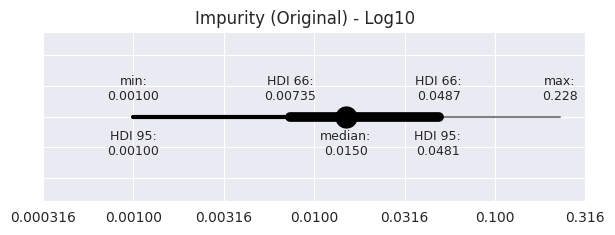

In [14]:
import numpy as np
plot_hdi(
    np.log10(df['impurity_original'].values + 0.001),
    transformation=lambda x: 10**x,
    title="Impurity (Original) - Log10"
)

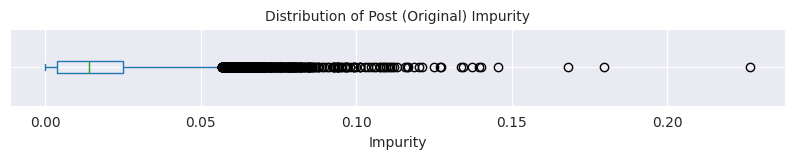

In [15]:
ax = df['impurity_original'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Post (Original) Impurity")
ax.set_xlabel("Impurity")
ax.set_yticklabels([])
ax;

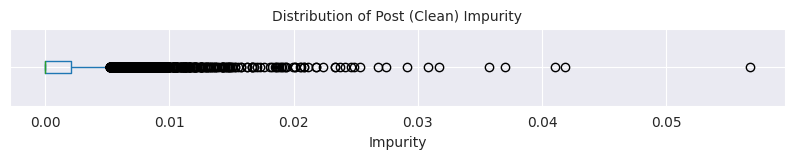

In [16]:
ax = df['impurity_clean'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Post (Clean) Impurity")
ax.set_xlabel("Impurity")
ax.set_yticklabels([])
ax;

In [17]:
df.sort_values('impurity_clean', ascending=False).head(2)

impurity_original  impurity_clean  \
17359               0.13            0.06   
8313                0.06            0.04   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [18]:
reddit['subreddit'].value_counts(ascending=False)

Harley                1000
Mustang               1000
saab                  1000
MPSelectMiniOwners    1000
mazda3                1000
Hyundai               1000
BMW                   1000
Trucks                1000
Porsche               1000
subaru                1000
Wrangler              1000
mercedes_benz         1000
Audi                  1000
teslamotors           1000
Honda                 1000
Volvo                 1000
volt                  1000
Lexus                 1000
Volkswagen            1000
4Runner               1000
Name: subreddit, dtype: int64

Explore idiosyncrasies of various columns, e.g. same speaker represented multiple ways.

---

## Explore Text Column|

### Top Words Used

In [19]:
remove_tokens = {'_number_', 'car'}
reddit_corpus.\
    count_lemmas(important_only=True).\
    query("token not in @remove_tokens").\
    head(30).\
    style.\
    bar(vmin=0, color='lightgray')

,token,count
1,look,11271
2,like,9466
3,drive,7574
4,know,7328
5,new,7238
6,want,6570
7,buy,6104
8,thank,6005
9,think,5851
10,mile,5776


---

### Distribution of Text Length

In [20]:
pd.Series(reddit_corpus.text_lengths(original=True))

0        764
1        320
2        446
3        385
4        280
        ... 
19995    277
19996    557
19997    326
19998    410
19999    531
Length: 20000, dtype: int64

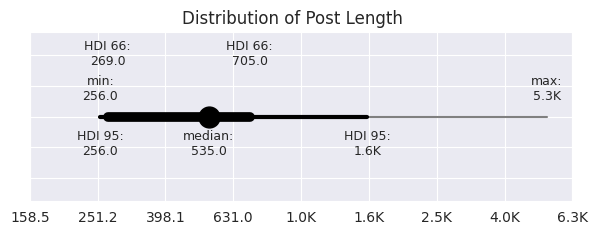

In [21]:
plot_hdi(
    np.log10(list(reddit_corpus.text_lengths(original=True))),
    transformation=lambda x: 10 ** x,
    title="Distribution of Post Length",
    vertical_factor_66=1.9,
)

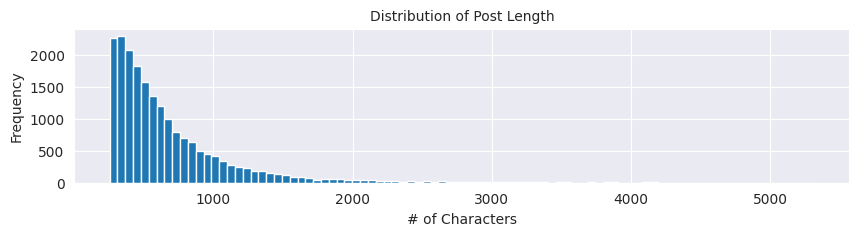

In [22]:
ax = pd.Series(reddit_corpus.text_lengths(original=True)).\
    plot(kind='hist', bins=90, figsize=(10, 2));
ax.set_title("Distribution of Post Length")
ax.set_xlabel("# of Characters")
ax;

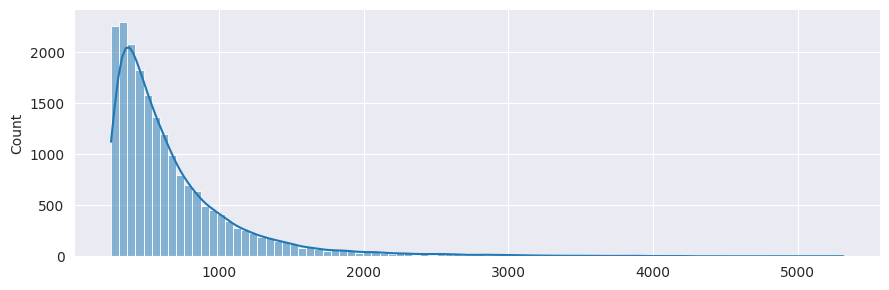

In [23]:
import seaborn as sns
sns.displot(list(reddit_corpus.text_lengths(original=True)), bins=90, kde=True, height=3, aspect=3);

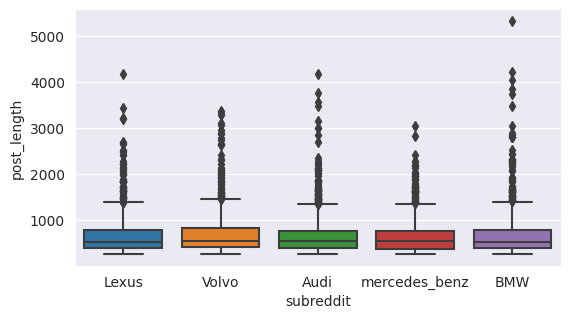

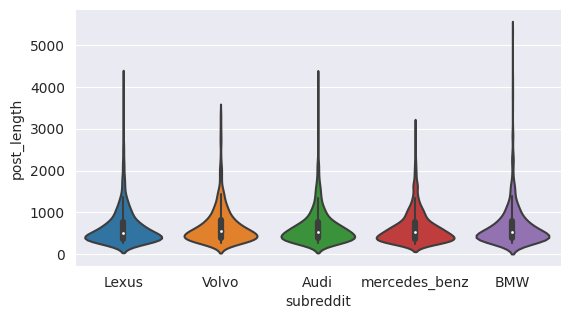

In [24]:
_df = pd.concat([
        reddit['subreddit'],
        pd.Series(reddit_corpus.text_lengths(original=True), name='post_length')
    ],
    axis=1
)
where = _df['subreddit'].isin([
    'Lexus', 
    'mercedes_benz',
    'Audi',
    'Volvo',
    'BMW',
])
g = sns.catplot(data=_df[where], x="subreddit", y="post_length", kind='box')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=_df[where], x="subreddit", y="post_length", kind='violin')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)

### Word Frequency

In [25]:
counts_df = reddit_corpus.\
    count_lemmas(important_only=True).\
    query("token not in @remove_tokens")
counts_df.head()

,token,count
1,look,11271
2,like,9466
3,drive,7574
4,know,7328
5,new,7238


In [26]:
import wordcloud
import helpsk.plot as hlpp
import matplotlib.pyplot as plt

def plot_wordcloud(frequency_dict):
    wc = wordcloud.WordCloud(background_color='white',
        #colormap='RdYlGn',
        colormap='tab20b',
        width=round(hlpp.STANDARD_WIDTH*100),
        height=round(hlpp.STANDARD_HEIGHT*100),
        max_words = 200, max_font_size=150,
        random_state=42
    )
    wc.generate_from_frequencies(frequency_dict)

    fig, ax = plt.subplots(figsize=(hlpp.STANDARD_WIDTH, hlpp.STANDARD_HEIGHT))
    ax.imshow(wc, interpolation='bilinear')
    #plt.title("XXX")
    plt.axis('off')

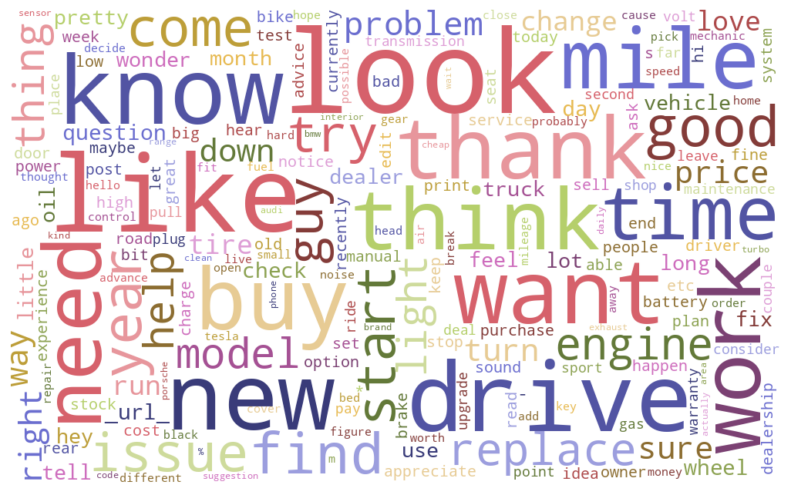

In [27]:
plot_wordcloud(counts_df.set_index('token').to_dict()['count']);

### TF-IDF

In [28]:
tf_idf_lemmas = reddit_corpus.\
    tf_idf_lemmas(important_only=True, min_count=20).\
    query("token not in @remove_tokens")

tf_idf_lemmas.\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['tf_idf']]).\
    bar(vmin=0, color='lightgray')

,token,count,tf_idf
1,look,11271,12282
2,drive,7574,11532
3,like,9466,11401
4,new,7238,10558
5,mile,5776,10069
6,know,7328,10041
7,want,6570,9874
8,work,5765,9864
9,buy,6104,9492
10,think,5851,9202


In [29]:
tf_idf_bi_grams = reddit_corpus.tf_idf_n_grams(n=2, min_count=20)

tf_idf_bi_grams.\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['tf_idf']]).\
    bar(vmin=0, color='lightgray')

,token,count,tf_idf
0,look-like,852,2843
1,hey-guy,853,2777
2,test-drive,789,2756
3,feel-like,766,2668
4,etc-.,616,2247
5,new-car,572,2145
6,oil-change,545,2130
7,greatly-appreciate,524,1965
8,brand-new,474,1864
9,month-ago,450,1765


In [30]:
count_adj_verbs = reddit_corpus.count_tokens(
    token_type='adjectives_verbs',
    min_count=10,
    # group_by=group_by,
    # count_once_per_doc=count_once_per_doc
)
count_adj_verbs.\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['count']]).\
    bar(vmin=0, color='lightgray')

,token,count
0,have,26298
1,get,15358
2,look,10571
3,go,9880
4,do,8534
5,know,7310
6,new,7009
7,want,6562
8,drive,6365
9,buy,5988


In [31]:
count_nouns = reddit_corpus.count_tokens(
    token_type='nouns',
    min_count=10,
    # group_by=group_by,
    # count_once_per_doc=count_once_per_doc
)
count_nouns.\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['count']]).\
    bar(vmin=0, color='lightgray')

,token,count
0,_number_,57664
1,car,20059
2,mile,5772
3,time,5260
4,thank,4940
5,year,4861
6,issue,4510
7,guy,3939
8,engine,3792
9,thing,3504


In [32]:
tf_idf_nouns = reddit_corpus.tf_idf_tokens(
    token_type='nouns',
    min_count=10,
)
tf_idf_nouns.\
    query("token != '_number_' and token != 'car'").\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['count']]).\
    bar(vmin=0, color='lightgray')

,token,count,tf_idf
2,mile,5772,10065.043854
3,time,5260,9027.268791
4,year,4861,8911.680534
5,issue,4510,8844.604059
6,engine,3792,8367.454539
7,guy,3939,7639.612529
8,model,3334,7564.608313
9,thank,4940,7530.593715
10,tire,2639,7266.650160
11,thing,3504,7144.600598


In [33]:
tf_idf_noun_phrases = reddit_corpus.tf_idf_tokens(
    token_type='noun_phrases',
    min_count=10,
)
tf_idf_noun_phrases.\
    head(20).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['count']]).\
    bar(vmin=0, color='lightgray')

,token,count,tf_idf
0,test-drive,686,2484.466673
1,new-car,571,2142.154275
2,oil-change,538,2109.642529
3,brand-new,466,1836.986275
4,steering-wheel,398,1676.983898
5,year-old,411,1673.280612
6,daily-driver,405,1644.578712
7,engine-light,347,1518.425654
8,good-deal,360,1502.835097
9,guy-think,355,1478.843772


---

In [34]:
tf_idf_lemmas

,token,count,tf_idf
1,look,11271,12281.65
2,drive,7574,11531.74
3,like,9466,11401.13
4,new,7238,10557.92
5,mile,5776,10069.03
...,...,...,...
4043,stone,20,140.16
4044,territory,20,140.16
4045,thx,20,140.16
4046,tooth,20,140.16


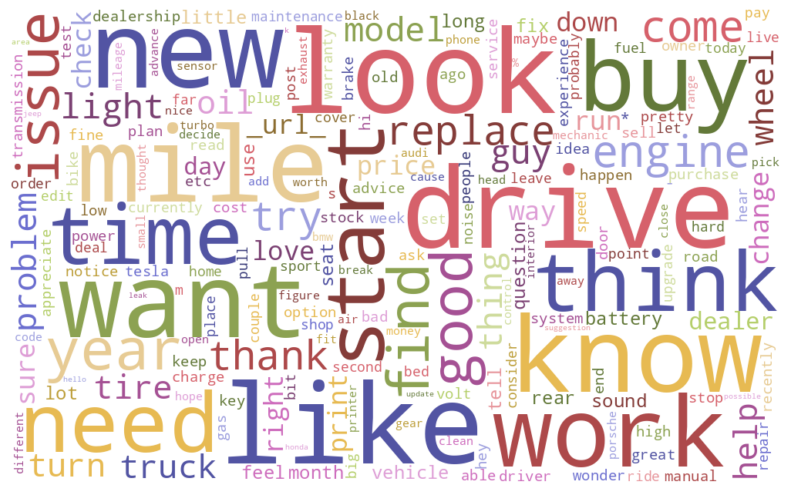

In [35]:
plot_wordcloud(tf_idf_lemmas.set_index('token').to_dict()['tf_idf']);

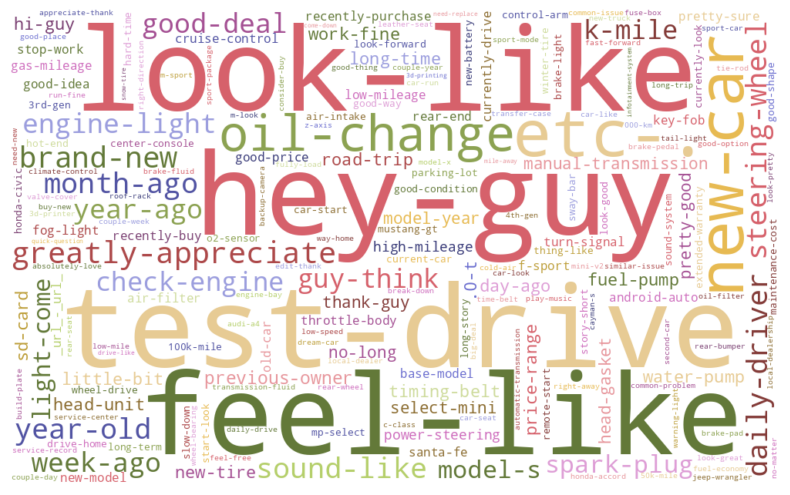

In [36]:
plot_wordcloud(tf_idf_bi_grams.set_index('token').to_dict()['tf_idf']);

#### By Subreddit

In [37]:
# tf_idf_lemmas = reddit_corpus.\
#     tf_idf_lemmas(important_only=True, min_count=20).\
#     query("token not in @remove_tokens")

# tf_idf_lemmas.\
#     head(20).\
#     style.\
#     format("{:.0f}", subset=pd.IndexSlice[:, ['tf_idf']]).\
#     bar(vmin=0, color='lightgray')

In [38]:
remove_tokens_subreddit = set(reddit.subreddit.str.lower().unique())

tf_idf_lemmas_subreddit = reddit_corpus.\
    tf_idf_lemmas(important_only=True, min_count=20, group_by=reddit['subreddit'].tolist()).\
    query("token not in @remove_tokens and token not in @remove_tokens_subreddit")
tf_idf_lemmas_subreddit.head()

,group,token,count,tf_idf,token_count,group_count
0,MPSelectMiniOwners,print,1830,6268.90,1886,52004
1,Trucks,truck,1763,5403.95,2177,53938
2,Harley,bike,1283,4434.95,1447,52315
4,teslamotors,tesla,1137,4074.43,1192,57065
6,MPSelectMiniOwners,printer,850,3241.20,854,52004


In [39]:
tf_idf_lemmas_subreddit.\
    sort_values(['group', 'tf_idf'], ascending=[True, False]).\
    groupby('group').\
    head(5).\
    style.\
    format("{:.0f}", subset=pd.IndexSlice[:, ['tf_idf']]).\
    bar(vmin=0, color='lightgray')

,group,token,count,tf_idf,token_count,group_count
55,4Runner,gen,296,1129,694,48227
60,4Runner,sr5,228,1077,234,48227
123,4Runner,look,696,758,11271,48227
160,4Runner,lift,180,682,787,48227
168,4Runner,mile,382,666,5776,48227
33,Audi,a4,351,1521,383,49993
104,Audi,a3,162,824,179,49993
133,Audi,s4,139,731,158,49993
155,Audi,look,633,690,11271,49993
192,Audi,quattro,117,635,123,49993


---

In [40]:
get_context_from_keyword(reddit.query("subreddit == 'Lexus'")['post'], keyword='think')

10435    ’s always bothered me and I didn’t  |think|  much of it after awhile. But I was
12874     insurance 100% paid off, so she's  |think| ing of trading it in and using the 
5597      I can run the check.<lb><lb>2.  I  |think|  the previous owner operated under 
18765                       Hey guys so I'm  |think| ing about getting a CPO by the end 
18765    area over the last month or 2 so I  |think|  I'm stuck with the premium package
6941     I shouldn't care what other people  |think| , but I worry that perhaps I'm miss
11675    short drive I took in one, but was  |think| ing I might get used to it? <lb><lb
12565    at they make per hour or what they  |think|  I would be able to get at their de
1405     o) with 110k  miles near me that I  |think|  would be great to check out if I c
1405     d of my thought process and what I  |think| . Any advice/suggestions/comments/c
dtype: object

In [41]:
get_context_from_keyword(reddit.query("subreddit == 'Volvo'")['post'], keyword='think')

5804                                 So I'm  |think| ing about selling my 850r slightly 
17739     thought was the front end.  I was  |think| ing wheel bearing or what I don't k
5275     sure theres some difference? i was  |think| ing of changing body panels and som
19180    enance records, but not all. Don’t  |think|  they did everything at the dealer,
2758     ith about 77k miles on it. But I'm  |think| ing about switching to a Volvo XC70
2758     ><lb>So I wanna ask you guy if you  |think|  it's a good trade? I find the stee
11818    w its just a dream but what do you  |think|  about a Polestar as an everyday dr
9229     y fine. One reason I'm inclined to  |think|  that is he *does* appear to have a
14094     pre-facelift.<lb><lb>Also I don't  |think|  it has rear arm rest or boot cover
18811    NII<lb><lb>Worst case scenario I'm  |think| ing the car could have been in an a
dtype: object

---

# Similarity Search

- search (find the most similar documents based on the text that I provide) - e.g. need to create a document from the text i provide, and then get the necessary vector (e.g. embeddings, tf-idf) and then find the docs via cosine similarity
- given a particular document (e.g. index?) get the top n siimilar douments

In [ ]:
text = "airbag warning light"

## TF-IDF

In [108]:
index_sims = reddit_corpus.get_similar_doc_indexes(text, how='tf_idf', top_n=5)
index_sims

(array([ 4905,  2093,  9035, 11017,  6893]),
 array([0.52209144, 0.4564647 , 0.44877298, 0.44173505, 0.42109761]))

In [109]:
[d.text() for d in reddit_corpus[index_sims[0]]]

["I took my 07 sportcombi into the dealer for the airbag recall last week and since then I've been getting an airbag malfunction warning about every other time I'm in the car. I called the dealership and they claimed its just a coincidence and that there is no way installing the airbag recall could have caused this.  Not that I find it hard to believe that it could be another electrical gremlin ( I see most of these warnings are caused by loose/bad connections somewhere) but I am a bit skeptical of the timing of it and the fact that they claim there is a zero percent chance they could have caused this. Can anyone who knows a bit more about replacing airbags or the airbag malfunction warning shed some light on this and let me know if the dealer is right?<lb><lb>Thanks!",
 "Hey there.  I have a 2008 Wrangler and I just put seat covers.  Now my airbag warning light goes on when I make turns.  I don't seem to have anything tangled up underneath the seat.  Seems like more than a coincidence

## Embeddings

In [ ]:
index_sims = reddit_corpus.get_similar_doc_indexes(text, how='embeddings', top_n=5)
index_sims

In [ ]:
[d.text() for d in reddit_corpus[index_sims[0]]]

---